# pySCENIC protocol: Pituitary Inflammation Standard Workflow

May 2022

Using ***aertslab/SCENICprotocol/notebooks/PBMC10k_SCENIC-protocol-CLI.ipynb*** as template, walk through an abbrevieated version of the standard workflow. 

The main purpose is to complete the SCENIC analysis workflow and export relevant results, which will be used in downstream analyses and plots.

Won't apply scanpy filters since we've already done that in R with `scater`.

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import anndata as ad

In [2]:
# set variables for file paths to read from and write to:

# set a working directory
wdir = "."
os.chdir( wdir )

# path to loom file with QC applied (created in rscripts, converted from Seurat object)
f_loom_path_scenic = "../data/scenic_protocol/files/hpcs_lps.loom"

# path to anndata object
f_anndata_path = "../data/processed/hpcs_lps_state_marked.h5ad"

# path to pyscenic output
f_pyscenic_output = "../data/scenic_protocol/files/hpcs_lps_pyscenic_output.loom"

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=300)

In [4]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 20

## Expression data import
There are several ways to import expression data. For simplicity we focus on getting the data into a Scanpy anndata object or a loom file.  Scanpy provides functions for reading in a wide variety of formats (described [here](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/index.html#reading)).

### Reading in expression data: anndata processed and exported from seurat_to_anndata script

In [5]:
adata = sc.read_h5ad(f_anndata_path)

## SCENIC steps

### STEP 1: Gene regulatory network inference, and generation of co-expression modules

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system. We use the counts matrix (without log transformation or further processing) from the loom file we wrote earlier.
_Output:_ List of adjacencies between a TF and its targets stored in `ADJACENCIES_FNAME`.

In [7]:
# transcription factors list
f_tfs = "../data/scenic_protocol/resources/allTFs_mm.txt" # mouse
# tf_names = load_tf_names( f_tfs )

<span style="color:orange">**The following step was performed using the aertslab/pyscenic:0.11.2 docker container.**</span>

In [19]:
## NOT DO
# !pyscenic grn {f_loom_path_scenic} \
#               {f_tfs} \
#               -o ../data/scenic_protocol/files/adj.csv \
#               --num_workers 6

read in the adjacencies matrix:

In [6]:
adjacencies = pd.read_csv("../data/scenic_protocol/files/adj.tsv", index_col=False, sep='\t')

In [17]:
adjacencies.head()

,TF,target,importance
0,Tbx19,Pomc,189.687483
1,Tbx19,Sparcl1,186.891465
2,Egr1,Fos,172.819609
3,Tbx19,AW551984,148.096466
4,Tbx19,Mcub,146.347121


### STEP 2-3: Regulon prediction aka cisTarget

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

_Output:_ List of adjacencies between a TF and its targets stored in `MOTIFS_FNAME`.

locations for ranking databases, and motif annotations:

In [8]:
import glob
# ranking databases
f_db_glob = "../data/scenic_protocol/resources/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "../data/scenic_protocol/resources/motifs-v9-nr.mgi-m0.001-o0.0.tbl"

Here, we use the `--mask_dropouts` option, which affects how the correlation between TF and target genes is calculated during module creation. It is important to note that prior to pySCENIC v0.9.18, the default behavior was to mask dropouts, while in v0.9.18 and later, the correlation is performed using the entire set of cells (including those with zero expression). When using the `modules_from_adjacencies` function directly in python instead of via the command line, the `rho_mask_dropouts` option can be used to control this.

<span style="color:orange">**The following step was performed using the aertslab/pyscenic:0.11.2 docker container.**</span>

In [20]:
## NOT DO
# !pyscenic ctx ../data/scenic_protocol/files/adj.tsv \
#               {f_db_names} \
#               --annotations_fname {f_motif_path} \
#               --expression_mtx_fname {f_loom_path_scenic} \
#               --mode "dask_multiprocessing" \
#               --output {'../data/scenic_protocol/files/regulons.csv'} \
#               --mask_dropouts \
#               --num_workers 16

### STEP 4: Cellular enrichment (aka AUCell) from CLI

It is important to check that most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC.
The following histogram gives an idea of the distribution and allows selection of an appropriate threshold.
In this plot, a few thresholds are highlighted, with the number of genes selected shown in red text and the corresponding percentile in parentheses).
See [the relevant section in the R tutorial](https://bioconductor.org/packages/devel/bioc/vignettes/AUCell/inst/doc/AUCell.html#build-gene-expression-rankings-for-each-cell) for more information.

By using the default setting for `--auc_threshold` of `0.05`, we see that **317** genes are selected for the rankings based on the plot below.

In [20]:
nGenesDetectedPerCell = pd.DataFrame(np.sum(adata.X>0, axis=1))
percentiles = nGenesDetectedPerCell.quantile(q=[.01, .05, .10, .50, 1])
print(percentiles)

            0
0.01   259.72
0.05   317.60
0.10   364.00
0.50   661.00
1.00  1124.00


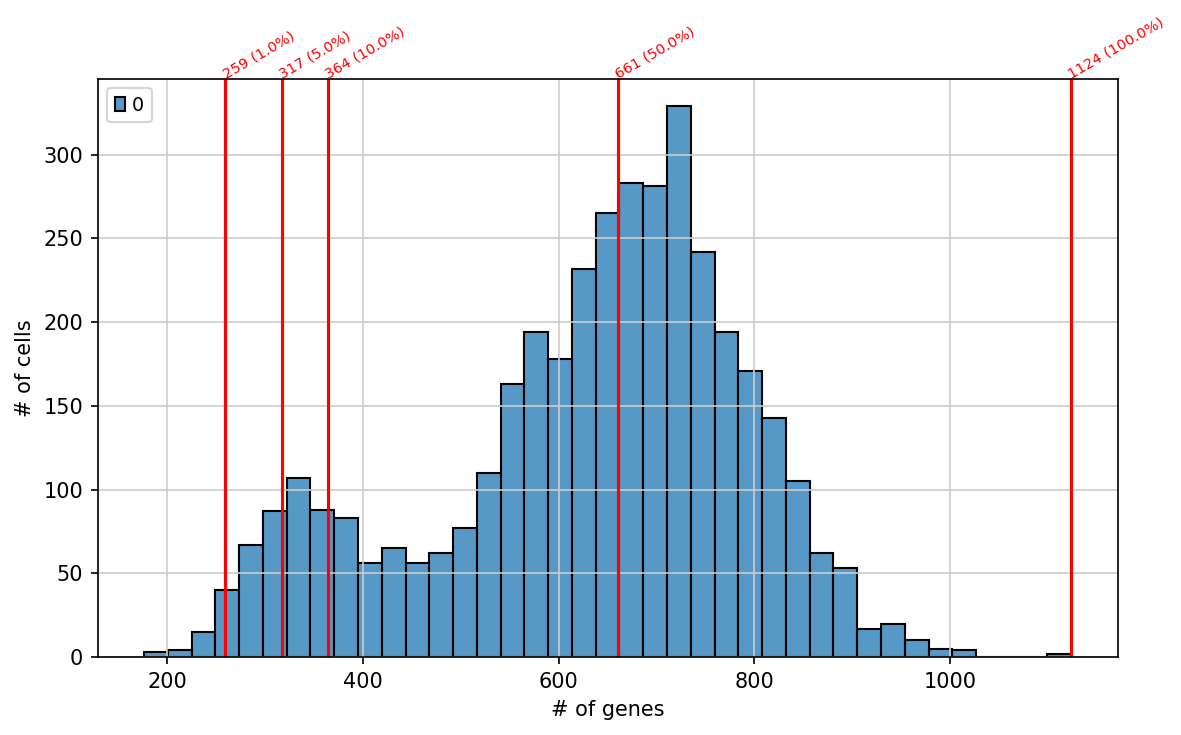

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.histplot(nGenesDetectedPerCell, kde=False, bins='fd')
for i, x in percentiles.iterrows():
    fig.gca().axvline(x=int(x), ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({float(i)*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

<span style="color:orange">**In the `pyscenic aucell` step, docker container `aertslab/pyscenic:0.11.2` failed due to loompy version [issues](https://github.com/aertslab/pySCENIC/issues/105). Run `pyscenic aucell` in CLI or in this notebook with `loompy==2.0.17`.**</span>

In [128]:
# !pyscenic aucell {f_loom_path_scenic} \
#                  {'../data/scenic_protocol/files/regulons.csv'} \
#                  --output {f_pyscenic_output} \
#                  --num_workers 16

/home/luolab/miniconda3/envs/scenic_protocol/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)

2021-12-28 13:31:05,837 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2021-12-28 13:31:06,373 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2021-12-28 13:31:10,339 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2021-12-28 13:31:14,132 - pyscenic.cli.pyscenic - INFO - Writing results to file.

2021-12-28 13:31:34,569 - pyscenic.cli.pyscenic - ERROR - Expression matrix should be provided in the loom file format.


### Visualization of SCENIC's AUC matrix

Perform non-linear dimension reduction on the AUC matrix with `umap`.

In [9]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [27]:
# import umap

# # UMAP
# runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
# dr_umap = runUmap( auc_mtx )
# pd.DataFrame(dr_umap, columns=['UMAPscenic_1', 'UMAPscenic_2'], index=auc_mtx.index).to_csv( "../data/scenic_protocol/files/scenic_umap_coords.txt", sep='\t')

/home/luolab/miniconda3/envs/scenic_protocol/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


### Step 5 - Regulon activity binarization

In [10]:
from pyscenic.binarization import binarize

In [11]:
bin_mtx, thresholds = binarize(auc_mtx, num_workers=16)

In [13]:
bin_mtx.to_csv('../data/scenic_protocol/files/bin_mtx.csv')
thresholds.to_frame().rename(columns={0:'threshold'}).to_csv('../data/scenic_protocol/files/thresholds.csv')